In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context

sc.settings.verbosity = 1

#sc.logging.print_versions()

import os 
import sys
import gc
import importlib

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
sns.set_style('white', {'axes.grid' : False})


def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

In [2]:
def deg(adata, groupby='leiden', groups='all', reference='rest', method='wilcoxon', save=None, use_raw=True, **kwds):
    sc.tl.rank_genes_groups(adata, groupby=groupby, method='wilcoxon', use_raw=use_raw, reference=reference, groups=groups, **kwds)
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    df = pd.DataFrame(
            {group + '_' + key: result[key][group]
             for group in groups for key in ['names', 'logfoldchanges','pvals_adj']})
    if save:
        df.to_csv(save, sep='\t')
    return df

def marker_filter(adata, deg, groupby, n=20, pcut=1e-100, fcut=1, ratio_cut=0.2, dratio=0, fc_ratio=1, dedup=True, use_raw=False, **kwds):
    celltypes = adata.obs[groupby].value_counts().index.to_list()
    
    if use_raw:
        adata = adata.raw.to_adata()
    
    if type(adata.X) is np.ndarray:
        import scipy.sparse as sps
        adata.X = sps.csr_matrix(adata.X)

    markers = dict()
    for ctype in celltypes:
        tmp = [x for x in deg.columns if ctype in x]
        tmp = deg.loc[:, tmp].copy()
        tmp = tmp.loc[(tmp.iloc[:, 2]<pcut) & (tmp.iloc[:, 1]>fcut), :]

        sub = adata[adata.obs[groupby]==ctype, tmp.iloc[:, 0]]
        sub2 = adata[adata.obs[groupby]!=ctype, tmp.iloc[:, 0]]
        tmp['ratio'] = np.array((sub.X > 0).sum(axis=0))[0, :]/sub.shape[0]
        tmp['ratio2'] = np.array((sub2.X > 0).sum(axis=0))[0, :]/sub2.shape[0]
        tmp['dratio'] = tmp['ratio'] - tmp['ratio2']
        tmp['fc_ratio'] = tmp['ratio'] / (tmp['ratio2']+1e-10)
        tmp = tmp.loc[tmp['ratio']>=ratio_cut, :]
        tmp = tmp.loc[tmp['dratio']>=dratio, :]
        tmp = tmp.loc[tmp['fc_ratio']>=fc_ratio, :]
        # print(ctype, tmp.shape)
        tmp = tmp.sort_values(by=ctype+'_logfoldchanges', ascending=False)
        # tmp = tmp.sort_values(by='score', ascending=False)
        markers[ctype] = tmp.iloc[:n, 0].to_list()
        
        if dedup:
            df = pd.DataFrame([markers.keys(), [len(markers[x]) for x in markers.keys()]], index=['key', 'len']).T
            df = df.sort_values(by='len')
            genes = set()
            for key in df['key']:
                markers[key] = list(set(markers[key]) - genes)
                genes = genes | set(markers[key])
    return markers

# region specific genes

In [3]:
# loading Stereo-seq data
st = sc.read_h5ad('/home/lee/project/v2/mouse_brain/h5ads/mouse_brain_merge2.h5ad')
st

AnnData object with n_obs × n_vars = 224218 × 36803
    obs: 'orig.ident', 'x', 'y', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'leiden', 'res_0.8', 'res_1', 'res_1.2', 'res_1.5', 'res_2', 'chip', 'cell_type_I', 'region'
    uns: 'region_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_bak', 'spin'
    layers: 'count'

In [8]:
# st_deg = deg(st, groupby='region', use_raw=False)
st_deg = pd.read_csv('mouse_brain_deg.csv', index_col=0)
markers_st = marker_filter(st, deg=st_deg, groupby='region', n=10, fc_ratio=5, dedup=False)
markers_st

{'TH': ['Prkcd', 'Synpo2'],
 'HY': [],
 'CA': [],
 'L5': [],
 'FT': [],
 'L2/3': [],
 'CTXsp': [],
 'L6': [],
 'PIR': [],
 'MB': [],
 'L4': [],
 'sAMY': [],
 'DG': ['Prox1'],
 'VS': ['Ecrg4', 'Igfbp2', 'Rbp1'],
 'CP': ['Gpr88',
  'Rgs9',
  'Rarb',
  'Penk',
  'Meis2',
  'Ppp1r1b',
  'Gm10754',
  'Pde1c',
  'Sv2c'],
 'COAp & PAA': [],
 'unknown': ['Kl',
  'Clic6',
  'F5',
  'Otx2os1',
  'Slc2a12',
  'Prlr',
  'Ace',
  'Col8a1',
  'Steap2',
  'Spag16'],
 'L1': [],
 'Meninges': [],
 'MH': ['D130079A08Rik',
  'Nwd2',
  'Kcnh8',
  'Kctd8',
  'Scube1',
  'Syt9',
  'Vav3',
  'Cpne4',
  'Dach1',
  'Gfra1']}

In [17]:
# loading Visium data
vs = sc.read_h5ad('/home/lixinxing/V2/FFPE_4/ffpe_scvi.h5ad')
vs = vs.raw.to_adata()
vs.obs['region2'].value_counts()

TH             1716
HY             1092
Cortex L6       883
AMY             846
Cortex L4       738
Cortex L2/3     636
PIR             571
Cortex L5       562
DG              537
Cortex L1       476
fi&opt&cpd      476
FT              374
CA              331
CP              325
VL              230
MLDG            186
MH               65
Name: region2, dtype: int64

In [18]:
region = 'TH'
th_markers = ['Prkcd', 'Synpo2']
df = vs[:, th_markers].to_df()
df['sample'] = vs.obs['sample']
df['class'] = 'out'
df.loc[vs.obs['region2']==region, 'class'] = 'in'
ratio_list = list()
for gene in th_markers:
    tmp = df.pivot_table(columns='class', index='sample', values=gene, aggfunc='mean')
    ratio_list.append(tmp['in']/tmp['out'])
th_df1 = pd.DataFrame(ratio_list, index=th_markers)
th_df1

sample,ffpe1_1,ffpe1_2,adult,fresh
Prkcd,15.031008,16.829620,9.83586,9.023853
Synpo2,17.379211,19.579685,15.39379,12.398839


In [19]:
df = st[:, th_markers].to_df()
df['sample'] = st.obs['sample']
df['class'] = 'out'
df.loc[st.obs['region']==region, 'class'] = 'in'
ratio_list = list()
for gene in th_markers:
    tmp = df.pivot_table(columns='class', index='sample', values=gene, aggfunc='mean')
    ratio_list.append(tmp['in']/tmp['out'])
th_df2 = pd.DataFrame(ratio_list, index=th_markers)
th_df2

sample,mouse.brain.160,mouse.brain.164,mouse.brain.168,A02384C3,A02384C4,mm_brain_v2
Prkcd,7.516416,5.144906,13.605476,11.948950,11.362467,14.079169
Synpo2,10.521534,8.194663,12.762951,7.851435,7.221859,8.241827


In [20]:
cp_markers = ['Gpr88', 'Rgs9', 'Rarb', 'Penk', 'Ppp1r1b', 'Pde1c']
region = 'CP'
df = vs[:, cp_markers].to_df()
df['sample'] = vs.obs['sample']
df['class'] = 'out'
df.loc[vs.obs['region2']==region, 'class'] = 'in'
ratio_list = list()
for gene in cp_markers:
    tmp = df.pivot_table(columns='class', index='sample', values=gene, aggfunc='mean')
    ratio_list.append(tmp['in']/tmp['out'])
cp_df1 = pd.DataFrame(ratio_list, index=cp_markers)
cp_df1

sample,ffpe1_1,ffpe1_2,adult,fresh
Gpr88,10.024780,10.002460,8.325859,6.863447
Rgs9,11.647229,13.417854,12.649517,10.451406
Rarb,7.579217,10.160967,6.372720,8.661691
Penk,9.522106,9.749866,6.287608,7.382745
Ppp1r1b,3.769145,3.907770,5.406185,5.806984
Pde1c,1.052129,0.000000,4.487006,2.949393


In [21]:
df = st[:, cp_markers].to_df()
df['sample'] = st.obs['sample']
df['class'] = 'out'
df.loc[st.obs['region']==region, 'class'] = 'in'
ratio_list = list()
for gene in cp_markers:
    tmp = df.pivot_table(columns='class', index='sample', values=gene, aggfunc='mean')
    ratio_list.append(tmp['in']/tmp['out'])
cp_df2 = pd.DataFrame(ratio_list, index=cp_markers)
cp_df2

sample,mouse.brain.160,mouse.brain.164,mouse.brain.168,A02384C3,A02384C4,mm_brain_v2
Gpr88,14.021946,12.126618,NaN,13.303231,11.859975,12.927938
Rgs9,15.698088,10.767829,NaN,7.911662,7.500493,8.742762
Rarb,7.953015,7.164316,NaN,7.589673,7.020085,9.939166
Penk,8.292915,7.844622,NaN,12.588241,11.660140,20.330072
Ppp1r1b,10.921165,9.289829,NaN,7.700418,8.004109,5.296876
Pde1c,3.582895,5.999312,NaN,3.669010,3.610253,5.026586


In [22]:
dg_markers = ['Prox1']
region = 'DG'
df = vs[:, dg_markers].to_df()
df['sample'] = vs.obs['sample']
df['class'] = 'out'
df.loc[vs.obs['region2']==region, 'class'] = 'in'
ratio_list = list()
for gene in dg_markers:
    tmp = df.pivot_table(columns='class', index='sample', values=gene, aggfunc='mean')
    ratio_list.append(tmp['in']/tmp['out'])
dg_df1 = pd.DataFrame(ratio_list, index=dg_markers)
dg_df1

sample,ffpe1_1,ffpe1_2,adult,fresh
Prox1,1.098886,0.850527,1.236715,0.654339


In [23]:
df = st[:, dg_markers].to_df()
df['sample'] = st.obs['sample']
df['class'] = 'out'
df.loc[st.obs['region']==region, 'class'] = 'in'
ratio_list = list()
for gene in dg_markers:
    tmp = df.pivot_table(columns='class', index='sample', values=gene, aggfunc='mean')
    ratio_list.append(tmp['in']/tmp['out'])
dg_df2 = pd.DataFrame(ratio_list, index=dg_markers)
dg_df2

sample,mouse.brain.160,mouse.brain.164,mouse.brain.168,A02384C3,A02384C4,mm_brain_v2
Prox1,5.055646,3.228403,8.647993,5.605278,5.551514,6.747692


In [24]:
ratio_visium = pd.concat([th_df1, cp_df1, dg_df1]).T
ratio_st = pd.concat([th_df2, cp_df2, dg_df2]).T
ratio_df = pd.concat([ratio_visium, ratio_st])
ratio_df['tech'] = ['visium_ff', 'visium_ff', 'visium_ffpe', 'visium_ffpe', 'StereoV1', 'StereoV1', 'StereoV1',  'StereoV2', 'StereoV2', 'StereoV2']
ratio_df

,Prkcd,Synpo2,Gpr88,Rgs9,Rarb,Penk,Ppp1r1b,Pde1c,Prox1,tech
sample,,,,,,,,,,
ffpe1_1,15.031008,17.379211,10.024780,11.647229,7.579217,9.522106,3.769145,1.052129,1.098886,visium_ff
ffpe1_2,16.829620,19.579685,10.002460,13.417854,10.160967,9.749866,3.907770,0.000000,0.850527,visium_ff
adult,9.835860,15.393790,8.325859,12.649517,6.372720,6.287608,5.406185,4.487006,1.236715,visium_ffpe
fresh,9.023853,12.398839,6.863447,10.451406,8.661691,7.382745,5.806984,2.949393,0.654339,visium_ffpe
mouse.brain.160,7.516416,10.521534,14.021946,15.698088,7.953015,8.292915,10.921165,3.582895,5.055646,StereoV1
mouse.brain.164,5.144906,8.194663,12.126618,10.767829,7.164316,7.844622,9.289829,5.999312,3.228403,StereoV1
mouse.brain.168,13.605476,12.762951,NaN,NaN,NaN,NaN,NaN,NaN,8.647993,StereoV1
A02384C3,11.948950,7.851435,13.303231,7.911662,7.589673,12.588241,7.700418,3.669010,5.605278,StereoV2
A02384C4,11.362467,7.221859,11.859975,7.500493,7.020085,11.660140,8.004109,3.610253,5.551514,StereoV2


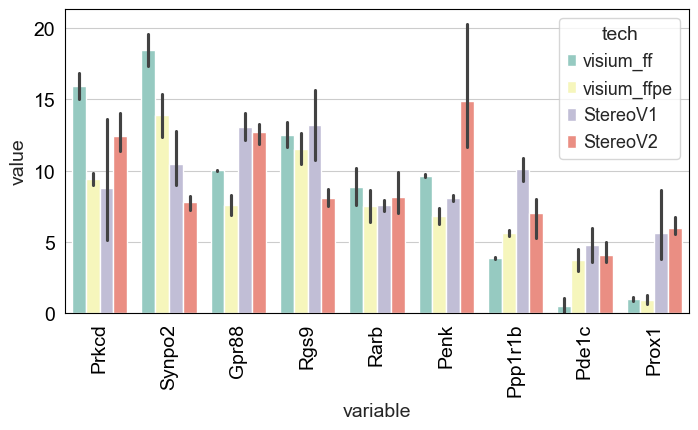

In [25]:
long_ratio = pd.melt(ratio_df, id_vars='tech', value_vars=ratio_df.columns)
plt.figure(figsize=(8, 4))
sns.barplot(data=long_ratio, x='variable', y='value', hue='tech', palette='Set3')
plt.xticks(rotation=90)
plt.savefig('marker_gene_signal_noise_ration.pdf')

In [27]:
# loading data for plot
adata = sc.read_h5ad('stereo_visium_merge.h5ad')

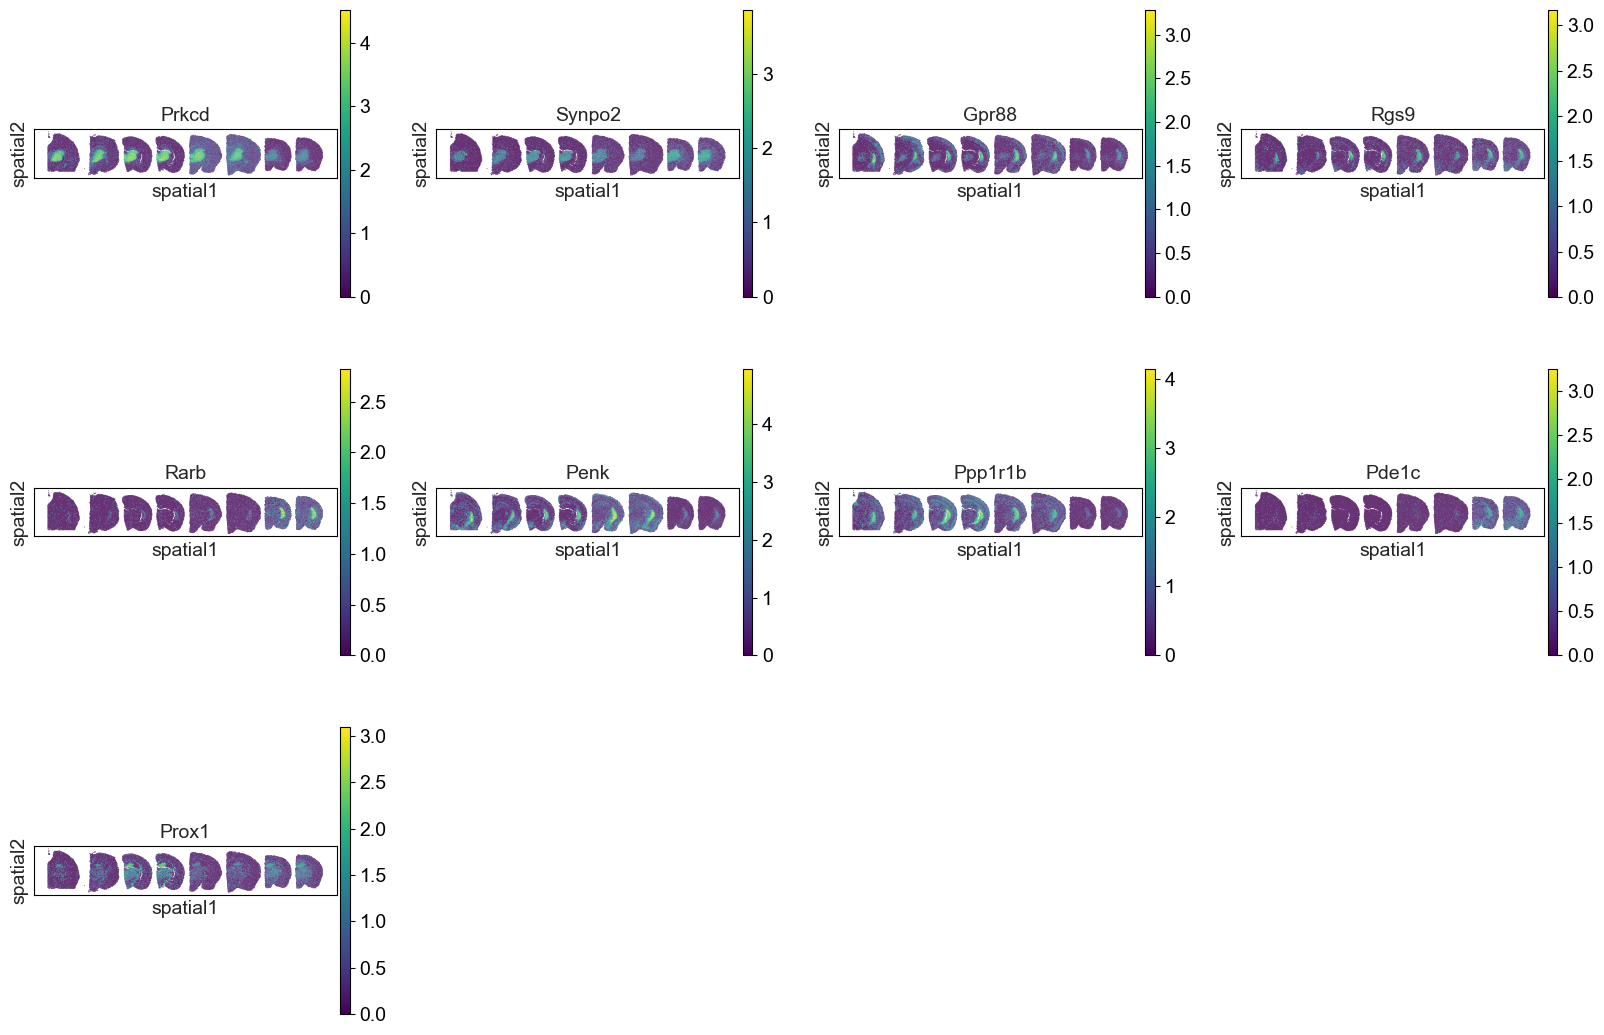

In [28]:
sc.pl.spatial(adata, color=ratio_df.columns[:-1], spot_size=250, cmap='viridis', save='marker_signal_noise_ratio.pdf')